In [1]:
%reset
import numpy as np 
import pandas as pd 
import xarray as xr 
import cartopy 
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import warnings
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
warnings.filterwarnings("ignore")
#from sklearn_xarray import Stacker, Select

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Shortcut 

[Latest cell](#working_cell)

# Load Data

In [2]:
root_path='/data/keeling/a/rytam2/ccf_model_spread/data/preprocessed/'
kernel_path='/data/keeling/a/rytam2/ccf_model_spread/data/raw/model_kernels/gcms/'

In [3]:
ts = xr.open_mfdataset(root_path+'ts_4xCO2_CMIP6_185001_199912.nc')
eis = xr.open_mfdataset(root_path+'eis_4xCO2_CMIP6_185001_199912.nc')
tadv = xr.open_mfdataset(root_path+'tadv_4xCO2_CMIP6_185001_199912.nc')
rh = xr.open_mfdataset(root_path+'hur_4xCO2_CMIP6_185001_199912.nc')
omega = xr.open_mfdataset(root_path+'wap_4xCO2_CMIP6_185001_199912.nc')
ws = xr.open_mfdataset(root_path+'ws_4xCO2_CMIP6_185001_199912.nc')

In [4]:
name_list = ['CanESM5','E3SM-1-0','GFDL-CM4','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC-ES2L',
            'MIROC6','MRI-ESM2-0','UKESM1-0-LL']
cmip6_list=['canesm5','e3sm','gfdl','hg3','ipsl','mies2l','mi6','mresm','ukesm']
rename_dict = dict(zip(sorted(name_list), sorted(cmip6_list)))

ts = ts.rename(rename_dict)
eis = eis.rename(rename_dict)
tadv = tadv.rename(rename_dict)
rh = rh.rename(rename_dict)
omega = omega.rename(rename_dict)
ws = ws.rename(rename_dict)

In [5]:
kernels_list = glob.glob(kernel_path+'*.nc');

dict_sst_kernels = {}
dict_eis_kernels = {}
dict_tadv_kernels = {}
dict_rh_kernels = {}
dict_omega_kernels = {}
dict_ws_kernels = {}

modelname_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl',
                'mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm'] #order must be sticktly followed to match kernels_list


for filename in kernels_list:
    kernel=xr.open_mfdataset(filename)
    j = kernels_list.index(filename)
    modelname=modelname_list[j]
    dict_sst_kernels["%s"%modelname] = kernel.isel(i=0).dRdxi
    dict_eis_kernels["%s"%modelname] = kernel.isel(i=1).dRdxi
    dict_tadv_kernels["%s"%modelname] = kernel.isel(i=2).dRdxi
    dict_rh_kernels["%s"%modelname] = kernel.isel(i=3).dRdxi
    dict_omega_kernels["%s"%modelname] = kernel.isel(i=4).dRdxi
    dict_ws_kernels["%s"%modelname] = kernel.isel(i=5).dRdxi
    
coords = {'lat':(['latitude'],kernel.lat.values),
         'lon':(['longitude'],kernel.lon.values)}

sst_kernels = xr.Dataset(data_vars=dict_sst_kernels,coords=coords);
eis_kernels = xr.Dataset(data_vars=dict_eis_kernels,coords=coords);
tadv_kernels = xr.Dataset(data_vars=dict_tadv_kernels,coords=coords);
rh_kernels = xr.Dataset(data_vars=dict_rh_kernels,coords=coords);
omega_kernels = xr.Dataset(data_vars=dict_omega_kernels,coords=coords);
ws_kernels = xr.Dataset(data_vars=dict_ws_kernels,coords=coords);

#rename dims for easier manipulation 
sst_kernels = sst_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
eis_kernels = eis_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
tadv_kernels = tadv_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
rh_kernels = rh_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
omega_kernels = omega_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
ws_kernels = ws_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});

# Remove Seasonality

In [6]:
# Remove seasonal cycle from measurements 
def remove_seasonality(x):
    return x - x.mean(dim='time')


ts_anom = ts.groupby('time.month').apply(remove_seasonality).assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_anom = eis.groupby('time.month').apply(remove_seasonality).assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_anom = tadv.groupby('time.month').apply(remove_seasonality).assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_anom = rh.groupby('time.month').apply(remove_seasonality).assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_anom = omega.groupby('time.month').apply(remove_seasonality).assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_anom = ws.groupby('time.month').apply(remove_seasonality).assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 

## Regression Coefficient $\beta$ and $\hat{dX_{i}}$ at all location

In [7]:
dict_beta_ts,dict_beta_eis,dict_beta_tadv,dict_beta_rh,dict_beta_omega,dict_beta_ws = {},{},{},{},{},{}
dict_ts_hat,dict_eis_hat,dict_tadv_hat,dict_rh_hat,dict_omega_hat,dict_ws_hat = {},{},{},{},{},{}
dict_ts_hat_fast,dict_eis_hat_fast,dict_tadv_hat_fast,dict_rh_hat_fast,dict_omega_hat_fast,dict_ws_hat_fast = {},{},{},{},{},{}
dict_ts_hat_slow,dict_eis_hat_slow,dict_tadv_hat_slow,dict_rh_hat_slow,dict_omega_hat_slow,dict_ws_hat_slow = {},{},{},{},{},{}
for modelname in cmip6_list:
    
    beta = ts_anom.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_ts[modelname] = beta
    dict_ts_hat[modelname] = beta.sel(degree=1)*(ts_anom.time.values[-1]-ts_anom.time.values[0])
    
    beta = eis_anom.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_eis[modelname] = beta
    dict_eis_hat[modelname] = beta.sel(degree=1)*(eis_anom.time[-1]-eis_anom.time[0])
    
    beta = tadv_anom.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_tadv[modelname] = beta
    dict_tadv_hat[modelname] = beta.sel(degree=1)*(tadv_anom.time[-1]-tadv_anom.time[0])
    
    beta = rh_anom.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_rh[modelname] = beta
    dict_rh_hat[modelname] = beta.sel(degree=1)*(rh_anom.time[-1]-rh_anom.time[0])
    
    beta = omega_anom.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_omega[modelname] = beta
    dict_omega_hat[modelname] = beta.sel(degree=1)*(omega_anom.time[-1]-omega_anom.time[0])
    
    beta = ws_anom.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_ws[modelname] = beta
    dict_ws_hat[modelname] = beta.sel(degree=1)*(ws_anom.time[-1]-ws_anom.time[0])
    
    
    
    beta = ts_anom.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_ts_hat_fast[modelname] = beta.sel(degree=1)*(ts_anom.time.isel(time=range(0,239)).values[-1]-ts_anom.time.isel(time=range(0,239)).values[0])
    beta = eis_anom.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_eis_hat_fast[modelname] = beta.sel(degree=1)*(eis_anom.isel(time=range(0,239)).time[-1]-eis_anom.isel(time=range(0,239)).time[0])
    beta = tadv_anom.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_tadv_hat_fast[modelname] = beta.sel(degree=1)*(tadv_anom.isel(time=range(0,239)).time[-1]-tadv_anom.isel(time=range(0,239)).time[0])
    beta = rh_anom.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_rh_hat_fast[modelname] = beta.sel(degree=1)*(rh_anom.isel(time=range(0,239)).time[-1]-rh_anom.isel(time=range(0,239)).time[0])
    beta = omega_anom.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_omega_hat_fast[modelname] = beta.sel(degree=1)*(omega_anom.isel(time=range(0,239)).time[-1]-omega_anom.isel(time=range(0,239)).time[0])
    beta = ws_anom.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_ws_hat_fast[modelname] = beta.sel(degree=1)*(ws_anom.isel(time=range(0,239)).time[-1]-ws_anom.isel(time=range(0,239)).time[0])
    
    
    beta = ts_anom.isel(time=range(240,1800)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_ts_hat_slow[modelname] = beta.sel(degree=1)*(ts_anom.time.isel(time=range(240,1800)).values[-1]-ts_anom.isel(time=range(240,1800)).time.values[0])
    beta = eis_anom.isel(time=range(240,1800)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_eis_hat_slow[modelname] = beta.sel(degree=1)*(eis_anom.isel(time=range(240,1800)).time[-1]-eis_anom.isel(time=range(240,1800)).time[0])
    beta = tadv_anom.isel(time=range(240,1800)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_tadv_hat_slow[modelname] = beta.sel(degree=1)*(tadv_anom.isel(time=range(240,1800)).time[-1]-tadv_anom.isel(time=range(240,1800)).time[0])
    beta = rh_anom.isel(time=range(240,1800)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_rh_hat_slow[modelname] = beta.sel(degree=1)*(rh_anom.isel(time=range(240,1800)).time[-1]-rh_anom.isel(time=range(240,1800)).time[0])
    beta = omega_anom.isel(time=range(240,1800)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_omega_hat_slow[modelname] = beta.sel(degree=1)*(omega_anom.isel(time=range(240,1800)).time[-1]-omega_anom.isel(time=range(240,1800)).time[0])
    beta = ws_anom.isel(time=range(240,1800)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_ws_hat_slow[modelname] = beta.sel(degree=1)*(ws_anom.isel(time=range(240,1800)).time[-1]-ws_anom.isel(time=range(240,1800)).time[0])
    
beta_ts = xr.Dataset(dict_beta_ts)
dSST_hat = xr.Dataset(dict_ts_hat)
dSST_hat_fast = xr.Dataset(dict_ts_hat_fast)
dSST_hat_slow = xr.Dataset(dict_ts_hat_slow)
dSST_hat_fast_bar = dSST_hat_fast.to_array(dim='models').mean('models')
dSST_hat_slow_bar = dSST_hat_slow.to_array(dim='models').mean('models')

beta_eis = xr.Dataset(dict_beta_eis)
dEIS_hat = xr.Dataset(dict_eis_hat)
dEIS_hat_fast = xr.Dataset(dict_eis_hat_fast)
dEIS_hat_slow = xr.Dataset(dict_eis_hat_slow)
dEIS_hat_fast_bar = dEIS_hat_fast.to_array(dim='models').mean('models')
dEIS_hat_slow_bar = dEIS_hat_slow.to_array(dim='models').mean('models')

beta_tadv = xr.Dataset(dict_beta_tadv)
dTadv_hat = xr.Dataset(dict_tadv_hat)
dTadv_hat_fast = xr.Dataset(dict_tadv_hat_fast)
dTadv_hat_slow = xr.Dataset(dict_tadv_hat_slow)
dTadv_hat_fast_bar = dTadv_hat_fast.to_array(dim='models').mean('models')
dTadv_hat_slow_bar = dTadv_hat_slow.to_array(dim='models').mean('models')


beta_rh = xr.Dataset(dict_beta_rh)
dRH_hat = xr.Dataset(dict_rh_hat)
dRH_hat_fast = xr.Dataset(dict_rh_hat_fast)
dRH_hat_slow = xr.Dataset(dict_rh_hat_slow)
dRH_hat_fast_bar = dRH_hat_fast.to_array(dim='models').mean('models')
dRH_hat_slow_bar = dRH_hat_slow.to_array(dim='models').mean('models')


beta_omega = xr.Dataset(dict_beta_omega)
dOmega_hat = xr.Dataset(dict_omega_hat)
dOmega_hat_fast = xr.Dataset(dict_omega_hat_fast)
dOmega_hat_slow = xr.Dataset(dict_omega_hat_slow)
dOmega_hat_fast_bar = dOmega_hat_fast.to_array(dim='models').mean('models')
dOmega_hat_slow_bar = dOmega_hat_slow.to_array(dim='models').mean('models')


beta_ws = xr.Dataset(dict_beta_ws)
dWS_hat = xr.Dataset(dict_ws_hat)
dWS_hat_fast = xr.Dataset(dict_ws_hat_fast)
dWS_hat_slow = xr.Dataset(dict_ws_hat_slow)
dWS_hat_fast_bar = dWS_hat_fast.to_array(dim='models').mean('models')
dWS_hat_slow_bar = dWS_hat_slow.to_array(dim='models').mean('models')

## Calculate $dX_{i}$ (compared to benchmark) 

In [8]:
# Change compared to 1982
def remove_time_mean(x):
    return x - x.isel(time=0)

dSST = ts_anom.apply(remove_time_mean)
dEIS = eis_anom.apply(remove_time_mean)
dTadv = tadv_anom.apply(remove_time_mean)
dRH = rh_anom.apply(remove_time_mean)
dOmega = omega_anom.apply(remove_time_mean)
dWS = ws_anom.apply(remove_time_mean)

## $dR_{ij}$ (per CCF, per ensemble member)

In [9]:
dR_SST = dSST * sst_kernels
dR_EIS = dEIS * eis_kernels
dR_Tadv = dTadv * tadv_kernels
dR_RH = dRH * rh_kernels
dR_Omega = dOmega * omega_kernels
dR_WS = dWS * ws_kernels

## $dR$ (sum of all CCFs per ensemble member) 

In [10]:
dR = dR_SST + dR_EIS + dR_Tadv + dR_RH + dR_Omega + dR_WS

## Global Mean $dR_{g}$

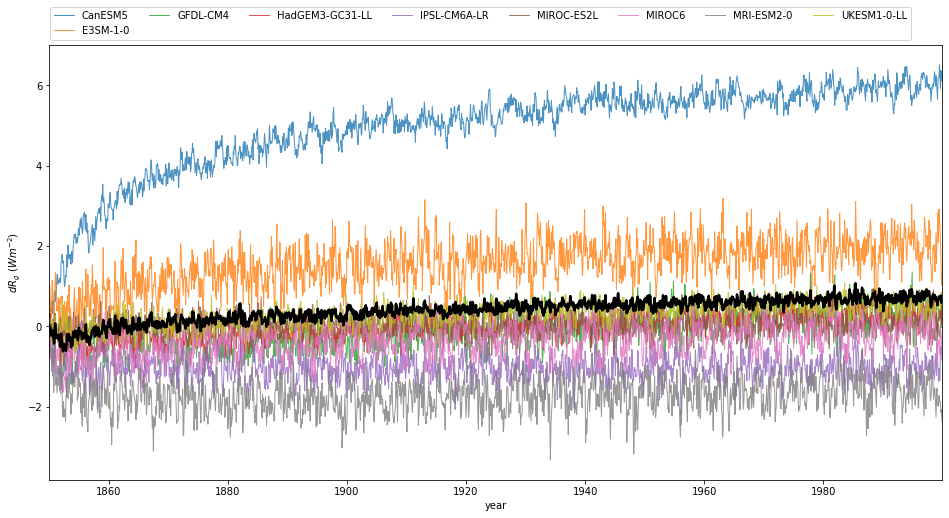

In [11]:
dR_g = dR.mean('lat').mean('lon').drop('plev')
fig = plt.figure(figsize=[16,8])
ax = plt.axes()
legend = []
for modelname in cmip6_list:
    plt.plot(dR_g.time,dR_g.get(modelname),alpha=0.8,linewidth=1)
    if modelname == 'canesm5':
        legend.append('CanESM5')
    elif modelname == 'e3sm':
        legend.append('E3SM-1-0')
    elif modelname == 'gfdl':
        legend.append('GFDL-CM4')
    elif modelname == 'hg3':
        legend.append('HadGEM3-GC31-LL')
    elif modelname == 'ipsl':
        legend.append('IPSL-CM6A-LR')
    elif modelname == 'mi6':
        legend.append('MIROC6')
    elif modelname == 'mies2l':
        legend.append('MIROC-ES2L')
    elif modelname == 'mresm':
        legend.append('MRI-ESM2-0')
    elif modelname == 'ukesm':
        legend.append('UKESM1-0-LL')
    
plt.plot(dR_g.time,dR_g.to_array('model').mean('model'),color='black',linewidth=2.5) 
ax.margins(x=0)
#legend.append('All-model average')

plt.legend(legend,bbox_to_anchor =(-.005,1),loc="lower left", ncol=8)
plt.xlabel('year'),plt.ylabel('$dR_{g}$ ($Wm^{-2}$)')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dR_global_tseries_4xCO2.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dSST_hat_fast_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',vmax=5,cbar_kwargs=dict(label='K'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
im = dEIS_hat_fast_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r', extend='both', vmax=5,vmin=-5,cbar_kwargs=dict(label='K'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dTadv_hat_fast_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r', extend='both', vmax=2e-5,vmin=-2e-5,cbar_kwargs=dict(label='K'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dRH_hat_fast_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r', extend='both', vmax=5,vmin=-5,cbar_kwargs=dict(label='(ratio)'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dOmega_hat_fast_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r', extend='both', vmax=.04,vmin=-.04,cbar_kwargs=dict(label='Pa $s^{-1}$'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dWS_hat_fast_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r', extend='both', vmax=1.5,vmin=-1.5,cbar_kwargs=dict(label='m$s^{-1}$'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
#fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.1,0.125,0.025),extend='both')

ax.set_title('Abrupt-4xCO2 Ensemble Mean dCCF across 60S to 60N in Year 1-20')
ax1.set_title('$dSST$')
ax2.set_title('$dEIS$')
ax3.set_title('$dTadv$')
ax4.set_title('$dRH$')
ax5.set_title('$dOmega$')
ax6.set_title('$dWS$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dCCF_fast_bar_across_all_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dSST_hat_slow_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',cbar_kwargs=dict(label='K'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
im = dEIS_hat_slow_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',cbar_kwargs=dict(label='K'),vmin=-5,vmax=5)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dTadv_hat_slow_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',cbar_kwargs=dict(label='K'),vmax=-1e-5, vmin=1e-5)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dRH_hat_slow_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',cbar_kwargs=dict(label='(unitless)'),vmin=-20,vmax=20)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dOmega_hat_slow_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',cbar_kwargs=dict(label='Pa $s^{-1$}'),vmin=-.1,vmax=.1)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
dWS_hat_slow_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',cbar_kwargs=dict(label='$m$s^{-1}$'))#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
#fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.1,0.125,0.025),extend='both')

ax.set_title('Abrupt-4xCO2 Ensemble Mean dCCF across 60S to 60N in Year 21-150')
ax1.set_title('$dSST$')
ax2.set_title('$dEIS$')
ax3.set_title('$dTadv$')
ax4.set_title('$dRH$')
ax5.set_title('$dOmega$')
ax6.set_title('$dWS$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dCCF_slow_bar_across_all_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

# Calculate contributions of CCFs to dR' 

### Ensemble Mean Change by dXi ($dR_{X}$)

#### Average of all models by taking dR_ensemble mean 

In [ ]:
# Get trend of dR_i
dict_beta_dR_SST,dict_beta_dR_EIS,dict_beta_dR_Tadv,dict_beta_dR_RH,dict_beta_dR_Omega,dict_beta_dR_WS,dict_beta_dR_Total = {},{},{},{},{},{},{}
dict_beta_dR_SST_fast,dict_beta_dR_EIS_fast,dict_beta_dR_Tadv_fast,dict_beta_dR_RH_fast,dict_beta_dR_Omega_fast,dict_beta_dR_WS_fast,dict_beta_dR_Total_fast = {},{},{},{},{},{},{}
dict_beta_dR_SST_slow,dict_beta_dR_EIS_slow,dict_beta_dR_Tadv_slow,dict_beta_dR_RH_slow,dict_beta_dR_Omega_slow,dict_beta_dR_WS_slow,dict_beta_dR_Total_slow = {},{},{},{},{},{},{}

for modelname in cmip6_list:
    
    beta = dR_SST.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_SST[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR_SST.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_SST_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR_SST.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_SST_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
    beta = dR_EIS.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_EIS[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR_EIS.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_EIS_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR_EIS.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_EIS_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
    beta = dR_Tadv.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Tadv[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR_Tadv.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Tadv_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR_Tadv.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Tadv_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
    beta = dR_RH.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_RH[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR_RH.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_RH_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR_RH.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_RH_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
    beta = dR_Omega.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Omega[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR_Omega.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Omega_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR_Omega.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Omega_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
    beta = dR_WS.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_WS[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR_WS.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_WS_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR_WS.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_WS_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
    beta = dR.get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Total[modelname] = beta.sel(degree=1).drop('degree')
    beta_fast = dR.isel(time=range(0,239)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Total_fast[modelname] = beta_fast.sel(degree=1).drop('degree')
    beta_slow = dR.isel(time=range(240,1800-1)).get(modelname).polyfit('time',1,skipna=True).polyfit_coefficients
    dict_beta_dR_Total_slow[modelname] = beta_slow.sel(degree=1).drop('degree')
    
beta_dR_SST = xr.Dataset(dict_beta_dR_SST)
beta_dR_EIS = xr.Dataset(dict_beta_dR_EIS)
beta_dR_Tadv = xr.Dataset(dict_beta_dR_Tadv)
beta_dR_RH = xr.Dataset(dict_beta_dR_RH)
beta_dR_Omega = xr.Dataset(dict_beta_dR_Omega)
beta_dR_WS = xr.Dataset(dict_beta_dR_WS)
beta_dR_Total = xr.Dataset(dict_beta_dR_Total)

beta_dR_SST_fast = xr.Dataset(dict_beta_dR_SST_fast)
beta_dR_EIS_fast = xr.Dataset(dict_beta_dR_EIS_fast)
beta_dR_Tadv_fast = xr.Dataset(dict_beta_dR_Tadv_fast)
beta_dR_RH_fast = xr.Dataset(dict_beta_dR_RH_fast)
beta_dR_Omega_fast = xr.Dataset(dict_beta_dR_Omega_fast)
beta_dR_WS_fast = xr.Dataset(dict_beta_dR_WS_fast)
beta_dR_Total_fast = xr.Dataset(dict_beta_dR_Total_fast)

beta_dR_SST_slow = xr.Dataset(dict_beta_dR_SST_slow)
beta_dR_EIS_slow = xr.Dataset(dict_beta_dR_EIS_slow)
beta_dR_Tadv_slow = xr.Dataset(dict_beta_dR_Tadv_slow)
beta_dR_RH_slow = xr.Dataset(dict_beta_dR_RH_slow)
beta_dR_Omega_slow = xr.Dataset(dict_beta_dR_Omega_slow)
beta_dR_WS_slow = xr.Dataset(dict_beta_dR_WS_slow)
beta_dR_Total_slow = xr.Dataset(dict_beta_dR_Total_slow)


beta_dR_SST_bar = beta_dR_SST.to_array(dim='models').mean('models')
beta_dR_EIS_bar = beta_dR_EIS.to_array(dim='models').mean('models')
beta_dR_Tadv_bar = beta_dR_Tadv.to_array(dim='models').mean('models')
beta_dR_RH_bar = beta_dR_RH.to_array(dim='models').mean('models')
beta_dR_Omega_bar = beta_dR_Omega.to_array(dim='models').mean('models')
beta_dR_WS_bar = beta_dR_WS.to_array(dim='models').mean('models')
beta_dR_Total_bar = beta_dR_Total.to_array(dim='models').mean('models')

beta_dR_SST_fast_bar = beta_dR_SST_fast.to_array(dim='models').mean('models')
beta_dR_EIS_fast_bar = beta_dR_EIS_fast.to_array(dim='models').mean('models')
beta_dR_Tadv_fast_bar = beta_dR_Tadv_fast.to_array(dim='models').mean('models')
beta_dR_RH_fast_bar = beta_dR_RH_fast.to_array(dim='models').mean('models')
beta_dR_Omega_fast_bar = beta_dR_Omega_fast.to_array(dim='models').mean('models')
beta_dR_WS_fast_bar = beta_dR_WS_fast.to_array(dim='models').mean('models')
beta_dR_Total_fast_bar = beta_dR_Total_fast.to_array(dim='models').mean('models')

beta_dR_SST_slow_bar = beta_dR_SST_slow.to_array(dim='models').mean('models')
beta_dR_EIS_slow_bar = beta_dR_EIS_slow.to_array(dim='models').mean('models')
beta_dR_Tadv_slow_bar = beta_dR_Tadv_slow.to_array(dim='models').mean('models')
beta_dR_RH_slow_bar = beta_dR_RH_slow.to_array(dim='models').mean('models')
beta_dR_Omega_slow_bar = beta_dR_Omega_slow.to_array(dim='models').mean('models')
beta_dR_WS_slow_bar = beta_dR_WS_slow.to_array(dim='models').mean('models')
beta_dR_Total_slow_bar = beta_dR_Total_slow.to_array(dim='models').mean('models')

In [ ]:
import matplotlib.offsetbox as offsetbox

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
ax.coastlines()


beta_dR_Total_bar.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',extend='both', cbar_kwargs={'ticks':np.arange(-0.1,0.15,0.025),'shrink': 0.75,'label':'$dR_{\u03A3 CCF} Trend $ ($Wm^{-2}yr^{-1}$)'},vmin=-.1,vmax=.1)

ax.set_title('Abrupt-4xCO2 Ensemble Mean Trend of $dR_{\u03A3 CCF}$ across 60S to 60N')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dR_trend_ensemble_mean_total_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

beta_dR_SST_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
im = beta_dR_EIS_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
beta_dR_Tadv_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
beta_dR_RH_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
beta_dR_Omega_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
beta_dR_WS_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.1,0.125,0.025),extend='both')

ax.set_title('Abrupt-4xCO2 Ensemble Mean Trend of $dR_{CCF}$ across 60S to 60N')
ax1.set_title('$dR_{SST}$')
ax2.set_title('$dR_{EIS}$')
ax3.set_title('$dR_{Tadv}$')
ax4.set_title('$dR_{RH}$')
ax5.set_title('$dR_{Omega}$')
ax6.set_title('$dR_{WS}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dR_trend_bar_across_all_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

beta_dR_SST_fast_bar.sel().plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.5,vmin=-0.5)
im = beta_dR_EIS_fast_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.5,vmin=-0.5)
beta_dR_Tadv_fast_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.5,vmin=-0.5)
beta_dR_RH_fast_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.5,vmin=-0.5)
beta_dR_Omega_fast_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.5,vmin=-0.5)
beta_dR_WS_fast_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.5,vmin=-0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.5,0.6,0.1),extend='both')

ax.set_title('Abrupt-4xCO2 Ensemble Mean Trend of $dR_{CCF}$ across 60S to 60N in Year 1-20')
ax1.set_title('$dR_{SST}$')
ax2.set_title('$dR_{EIS}$')
ax3.set_title('$dR_{Tadv}$')
ax4.set_title('$dR_{RH}$')
ax5.set_title('$dR_{Omega}$')
ax6.set_title('$dR_{WS}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dR_trend_fast_bar_across_all_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

beta_dR_SST_slow_bar.sel().plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.05,vmin=-0.05)
im = beta_dR_EIS_slow_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.05,vmin=-0.05)
beta_dR_Tadv_slow_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.05,vmin=-0.05)
beta_dR_RH_slow_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.05,vmin=-0.05)
beta_dR_Omega_slow_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.05,vmin=-0.05)
beta_dR_WS_slow_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend=True, vmax=0.05,vmin=-0.05)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.05,0.051,0.01),extend='both')

ax.set_title('Abrupt-4xCO2 Ensemble Mean Trend of $dR_{CCF}$ across 60S to 60N in Year 20-150')
ax1.set_title('$dR_{SST}$')
ax2.set_title('$dR_{EIS}$')
ax3.set_title('$dR_{Tadv}$')
ax4.set_title('$dR_{RH}$')
ax5.set_title('$dR_{Omega}$')
ax6.set_title('$dR_{WS}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dR_trend_slow_bar_across_all_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

##  $\hat{dR_{i}}$ SD across models (calculated with approximated $dX_{i}$ (i.e. $\hat{dX_{i}}$))

In [ ]:
dR_SST_hat = sst_kernels*dSST_hat
dR_EIS_hat = eis_kernels*dEIS_hat
dR_Tadv_hat = tadv_kernels*dTadv_hat
dR_RH_hat = rh_kernels*dRH_hat
dR_Omega_hat = omega_kernels*dOmega_hat
dR_WS_hat = ws_kernels*dWS_hat
dR_hat = dR_SST_hat+dR_EIS_hat+dR_Tadv_hat+dR_RH_hat+dR_Omega_hat+dR_WS_hat

dR_SST_hat_bar = dR_SST_hat.to_array(dim='models').mean('models')
dR_EIS_hat_bar = dR_EIS_hat.to_array(dim='models').mean('models')
dR_Tadv_hat_bar = dR_Tadv_hat.to_array(dim='models').mean('models')
dR_RH_hat_bar = dR_RH_hat.to_array(dim='models').mean('models')
dR_Omega_hat_bar = dR_Omega_hat.to_array(dim='models').mean('models')
dR_WS_hat_bar = dR_WS_hat.to_array(dim='models').mean('models')
dR_hat_bar = dR_hat.to_array(dim='models').mean('models')

std_dR_SST_hat = dR_SST_hat.to_array(dim='models').std('models')
std_dR_EIS_hat = dR_EIS_hat.to_array(dim='models').std('models')
std_dR_Tadv_hat = dR_Tadv_hat.to_array(dim='models').std('models')
std_dR_RH_hat = dR_RH_hat.to_array(dim='models').std('models')
std_dR_Omega_hat = dR_Omega_hat.to_array(dim='models').std('models')
std_dR_WS_hat = dR_WS_hat.to_array(dim='models').std('models')
std_dR_hat = dR_hat.to_array(dim='models').std('models')



dR_SST_hat_fast = sst_kernels*dSST_hat_fast
dR_EIS_hat_fast = eis_kernels*dEIS_hat_fast
dR_Tadv_hat_fast = tadv_kernels*dTadv_hat_fast
dR_RH_hat_fast = rh_kernels*dRH_hat_fast
dR_Omega_hat_fast = omega_kernels*dOmega_hat_fast
dR_WS_hat_fast = ws_kernels*dWS_hat_fast
dR_hat_fast = dR_SST_hat_fast+dR_EIS_hat_fast+dR_Tadv_hat_fast+dR_RH_hat_fast+dR_Omega_hat_fast+dR_WS_hat_fast

dR_SST_hat_fast_bar = dR_SST_hat_fast.to_array(dim='models').mean('models')
dR_EIS_hat_fast_bar = dR_EIS_hat_fast.to_array(dim='models').mean('models')
dR_Tadv_hat_fast_bar = dR_Tadv_hat_fast.to_array(dim='models').mean('models')
dR_RH_hat_fast_bar = dR_RH_hat_fast.to_array(dim='models').mean('models')
dR_Omega_hat_fast_bar = dR_Omega_hat_fast.to_array(dim='models').mean('models')
dR_WS_hat_fast_bar = dR_WS_hat_fast.to_array(dim='models').mean('models')
dR_hat_fast_bar = dR_hat_fast.to_array(dim='models').mean('models')

std_dR_SST_hat_fast = dR_SST_hat_fast.to_array(dim='models').std('models')
std_dR_EIS_hat_fast = dR_EIS_hat_fast.to_array(dim='models').std('models')
std_dR_Tadv_hat_fast = dR_Tadv_hat_fast.to_array(dim='models').std('models')
std_dR_RH_hat_fast = dR_RH_hat_fast.to_array(dim='models').std('models')
std_dR_Omega_hat_fast = dR_Omega_hat_fast.to_array(dim='models').std('models')
std_dR_WS_hat_fast = dR_WS_hat_fast.to_array(dim='models').std('models')
std_dR_hat_fast = dR_hat_fast.to_array(dim='models').std('models')




dR_SST_hat_slow = sst_kernels*dSST_hat_slow
dR_EIS_hat_slow = eis_kernels*dEIS_hat_slow
dR_Tadv_hat_slow = tadv_kernels*dTadv_hat_slow
dR_RH_hat_slow = rh_kernels*dRH_hat_slow
dR_Omega_hat_slow = omega_kernels*dOmega_hat_slow
dR_WS_hat_slow = ws_kernels*dWS_hat_slow
dR_hat_slow = dR_SST_hat_slow+dR_EIS_hat_slow+dR_Tadv_hat_slow+dR_RH_hat_slow+dR_Omega_hat_slow+dR_WS_hat_slow

dR_SST_hat_slow_bar = dR_SST_hat_slow.to_array(dim='models').mean('models')
dR_EIS_hat_slow_bar = dR_EIS_hat_slow.to_array(dim='models').mean('models')
dR_Tadv_hat_slow_bar = dR_Tadv_hat_slow.to_array(dim='models').mean('models')
dR_RH_hat_slow_bar = dR_RH_hat_slow.to_array(dim='models').mean('models')
dR_Omega_hat_slow_bar = dR_Omega_hat_slow.to_array(dim='models').mean('models')
dR_WS_hat_slow_bar = dR_WS_hat_slow.to_array(dim='models').mean('models')
dR_hat_slow_bar = dR_hat_slow.to_array(dim='models').mean('models')

std_dR_SST_hat_slow = dR_SST_hat_slow.to_array(dim='models').std('models')
std_dR_EIS_hat_slow = dR_EIS_hat_slow.to_array(dim='models').std('models')
std_dR_Tadv_hat_slow = dR_Tadv_hat_slow.to_array(dim='models').std('models')
std_dR_RH_hat_slow = dR_RH_hat_slow.to_array(dim='models').std('models')
std_dR_Omega_hat_slow = dR_Omega_hat_slow.to_array(dim='models').std('models')
std_dR_WS_hat_slow = dR_WS_hat_slow.to_array(dim='models').std('models')
std_dR_hat_slow = dR_hat_slow.to_array(dim='models').std('models')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dR_SST_hat_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
im = dR_EIS_hat_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_Tadv_hat_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_RH_hat_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_Omega_hat_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_WS_hat_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',extend='max')


ax.set_title('Abrupt-4xCO2 Approximated Flux Change Average $\hat{dR_{i}}$ across 60S to 60N across CMIP6 Models')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dRi_hat_bar_across_models_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dR_SST_hat_fast_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=20,vmin=-20)
im = dR_EIS_hat_fast_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=20,vmin=-20)
dR_Tadv_hat_fast_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=20,vmin=-20)
dR_RH_hat_fast_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=20,vmin=-20)
dR_Omega_hat_fast_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=20,vmin=-20)
dR_WS_hat_fast_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=20,vmin=-20)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',extend='both')


ax.set_title('Abrupt-4xCO2 Approximated Flux Change Average $\hat{dR_{i}}$ across 60S to 60N across CMIP6 Models in Year 1-20')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dRi_hat_fast_bar_across_models_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dR_SST_hat_slow_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
im = dR_EIS_hat_slow_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_Tadv_hat_slow_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_RH_hat_slow_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_Omega_hat_slow_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)
dR_WS_hat_slow_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',add_colorbar=False, extend='both', vmax=4,vmin=-4)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',extend='both')


ax.set_title('Abrupt-4xCO2 Approximated Flux Change Average $\hat{dR_{i}}$ across 60S to 60N across CMIP6 Models in Year 21-150')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/dRi_hat_slow_bar_across_models_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

std_dR_SST_hat.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=5,vmin=0)
im = std_dR_EIS_hat.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=5,vmin=0)
std_dR_Tadv_hat.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=5,vmin=0)
std_dR_RH_hat.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=5,vmin=0)
std_dR_Omega_hat.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=5,vmin=0)
std_dR_WS_hat.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5,vmin=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',ticks=np.arange(0,5.5,1),extend='max')


ax.set_title('Abrupt-4xCO2 Standard Deviation of $\hat{dR_{i}}$ across 60S to 60N across CMIP6 Models')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/std_dRi_hat_across_models_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

std_dR_SST_hat_fast.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=30,vmin=0)
im = std_dR_EIS_hat_fast.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=30,vmin=0)
std_dR_Tadv_hat_fast.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=30,vmin=0)
std_dR_RH_hat_fast.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=30,vmin=0)
std_dR_Omega_hat_fast.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=30,vmin=0)
std_dR_WS_hat_fast.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=30,vmin=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',ticks=np.arange(0,20.5,5),extend='max')


ax.set_title('Abrupt-4xCO2 Standard Deviation of $\hat{dR_{i}}$ across 60S to 60N across CMIP6 Models in Year 1-20')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/std_dRi_hat_fast_across_models_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

std_dR_SST_hat_slow.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=5,vmin=0)
im = std_dR_EIS_hat_slow.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=5,vmin=0)
std_dR_Tadv_hat_slow.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=5,vmin=0)
std_dR_RH_hat_slow.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=5,vmin=0)
std_dR_Omega_hat_slow.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=5,vmin=0)
std_dR_WS_hat_slow.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5,vmin=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',ticks=np.arange(0,5.5,1),extend='max')


ax.set_title('Abrupt-4xCO2 Standard Deviation of $\hat{dR_{i}}$ across 60S to 60N across CMIP6 Models in Year 21-150')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/std_dRi_hat_slow_across_models_6maps_singcolorbar_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

# Uncertainty Analysis 

In [ ]:
# Model Averaged values 
dSST_bar = dSST_hat.to_array('models').mean('models')
dEIS_bar = dEIS_hat.to_array('models').mean('models')
dTadv_bar = dTadv_hat.to_array('models').mean('models')
dRH_bar = dRH_hat.to_array('models').mean('models')
dOmega_bar = dOmega_hat.to_array('models').mean('models')
dWS_bar = dWS_hat.to_array('models').mean('models')
#Model deviations 
dEIS_prime = dEIS_hat - dEIS_bar
dTadv_prime = dTadv_hat - dTadv_bar
dRH_prime = dRH_hat - dRH_bar
dOmega_prime = dOmega_hat - dOmega_bar
dWS_prime = dWS_hat - dWS_bar



# Model Averaged values 
dSST_fast_bar = dSST_hat_fast.to_array('models').mean('models')
dEIS_fast_bar = dEIS_hat_fast.to_array('models').mean('models')
dTadv_fast_bar = dTadv_hat_fast.to_array('models').mean('models')
dRH_fast_bar = dRH_hat_fast.to_array('models').mean('models')
dOmega_fast_bar = dOmega_hat_fast.to_array('models').mean('models')
dWS_fast_bar = dWS_hat_fast.to_array('models').mean('models')
#Model deviations 
dEIS_fast_prime = dEIS_hat_fast - dEIS_fast_bar
dTadv_fast_prime = dTadv_hat_fast - dTadv_fast_bar
dRH_fast_prime = dRH_hat_fast - dRH_fast_bar
dOmega_fast_prime = dOmega_hat_fast - dOmega_fast_bar
dWS_fast_prime = dWS_hat_fast - dWS_fast_bar



# Model Averaged values 
dSST_slow_bar = dSST_hat_slow.to_array('models').mean('models')
dEIS_slow_bar = dEIS_hat_slow.to_array('models').mean('models')
dTadv_slow_bar = dTadv_hat_slow.to_array('models').mean('models')
dRH_slow_bar = dRH_hat_slow.to_array('models').mean('models')
dOmega_slow_bar = dOmega_hat_slow.to_array('models').mean('models')
dWS_slow_bar = dWS_hat_slow.to_array('models').mean('models')
#Model deviations 
dEIS_slow_prime = dEIS_hat_slow - dEIS_slow_bar
dTadv_slow_prime = dTadv_hat_slow - dTadv_slow_bar
dRH_slow_prime = dRH_hat_slow - dRH_slow_bar
dOmega_slow_prime = dOmega_hat_slow - dOmega_slow_bar
dWS_slow_prime = dWS_hat_slow - dWS_slow_bar



sst_kernels_bar = sst_kernels.to_array('models').mean('models')
eis_kernels_bar = eis_kernels.to_array('models').mean('models')
tadv_kernels_bar = tadv_kernels.to_array('models').mean('models')
rh_kernels_bar = rh_kernels.to_array('models').mean('models')
omega_kernels_bar = omega_kernels.to_array('models').mean('models')
ws_kernels_bar = ws_kernels.to_array('models').mean('models')
# kernel deviation from mean 
sst_kernels_prime = sst_kernels-sst_kernels_bar
eis_kernels_prime = eis_kernels-eis_kernels_bar
tadv_kernels_prime = tadv_kernels-tadv_kernels_bar
rh_kernels_prime = rh_kernels-rh_kernels_bar
omega_kernels_prime = omega_kernels-omega_kernels_bar
ws_kernels_prime = ws_kernels-ws_kernels_bar

## Assumption of dR = dX_bar* kernel_prime + dX_prime*kernel_bar Test

In [ ]:
# Model SST Sensitivity
dR_model_to_sst_prime = sst_kernels_prime*dSST_bar
dR_model_to_sst_prime_var = dR_model_to_sst_prime.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime = (eis_kernels_bar*dEIS_prime)
dR_intrin_eis_prime_var = dR_intrin_eis_prime.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime = (eis_kernels_prime*dEIS_bar)
dR_model_to_eis_prime_var = dR_model_to_eis_prime.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime = (tadv_kernels_bar*dTadv_prime)
dR_intrin_tadv_prime_var = dR_intrin_tadv_prime.to_array(dim='models').var('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime = (tadv_kernels_prime*dTadv_bar)
dR_model_to_tadv_prime_var = dR_model_to_tadv_prime.to_array(dim='models').var('models')


# Intrinsic RH changes 
dR_intrin_rh_prime = (rh_kernels_bar*dRH_prime)
dR_intrin_rh_prime_var = dR_intrin_rh_prime.to_array(dim='models').var('models')

# Model RH Sensitivity 
dR_model_to_rh_prime = (rh_kernels_prime*dRH_bar)
dR_model_to_rh_prime_var = dR_model_to_rh_prime.to_array(dim='models').var('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime = (omega_kernels_bar*dOmega_prime)
dR_intrin_omega_prime_var = dR_intrin_omega_prime.to_array(dim='models').var('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime = (omega_kernels_prime*dOmega_bar)
dR_model_to_omega_prime_var = dR_model_to_omega_prime.to_array(dim='models').var('models')

# Intrinsic WS changes 
dR_intrin_ws_prime = (ws_kernels_bar*dWS_prime)
dR_intrin_ws_prime_var = dR_intrin_ws_prime.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime = (ws_kernels_prime*dWS_bar)
dR_model_to_ws_prime_var = dR_model_to_ws_prime.to_array(dim='models').var('models')

dR_intrin_var = dR_intrin_eis_prime_var+dR_intrin_tadv_prime_var+dR_intrin_rh_prime_var+dR_intrin_omega_prime_var+dR_intrin_ws_prime_var
dR_sensitivity_var = dR_model_to_sst_prime_var+dR_model_to_eis_prime_var+dR_model_to_tadv_prime_var+dR_model_to_rh_prime_var+dR_model_to_omega_prime_var+dR_model_to_ws_prime_var
dR_hat_var = dR_hat.to_array('models').var('models')
var_ratio = (dR_intrin_var+dR_sensitivity_var)/dR_hat_var
var_diff = dR_hat_var-(dR_intrin_var+dR_sensitivity_var)

In [ ]:
#figcheck 
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(), ax4.coastlines()

im = dR_hat_var.plot(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False,vmin=0,vmax =25,cmap='plasma',)
dR_sensitivity_var.plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=0,vmax=25,cmap='plasma',)
dR_intrin_var.plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=0,vmax=25,cmap='plasma')
var_diff.plot(ax=ax4,transform=ccrs.PlateCarree(),add_colorbar=False,cmap='plasma',extend='max', vmin=0, vmax=10)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{predicted}$ ($Wm^{-2}$)',extend='max')

#ax.set_title("Var(dR), Var((dR/dX)'$\overline{dX}$) and $dX'*\overline{dR/dX}$ across 60S to 60N (1982-2008)")
ax1.set_title('Var(dR)')
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)")
ax3.set_title("Var($\overline{dR/dX}$*dX')")
ax4.set_title("a - (b+c)")
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/var_dR_sensitivity_intrin_diff_4maps_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
# Model SST Sensitivity
dR_model_to_sst_prime_fast = sst_kernels_prime*dSST_fast_bar
dR_model_to_sst_prime_fast_var = dR_model_to_sst_prime_fast.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_fast = (eis_kernels_bar*dEIS_fast_prime)
dR_intrin_eis_prime_fast_var = dR_intrin_eis_prime_fast.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_fast = (eis_kernels_prime*dEIS_fast_bar)
dR_model_to_eis_prime_fast_var = dR_model_to_eis_prime_fast.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_fast = (tadv_kernels_bar*dTadv_fast_prime)
dR_intrin_tadv_prime_fast_var = dR_intrin_tadv_prime_fast.to_array(dim='models').var('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_fast = (tadv_kernels_prime*dTadv_fast_bar)
dR_model_to_tadv_prime_fast_var = dR_model_to_tadv_prime_fast.to_array(dim='models').var('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_fast = (rh_kernels_bar*dRH_fast_prime)
dR_intrin_rh_prime_fast_var = dR_intrin_rh_prime_fast.to_array(dim='models').var('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_fast = (rh_kernels_prime*dRH_fast_bar)
dR_model_to_rh_prime_fast_var = dR_model_to_rh_prime_fast.to_array(dim='models').var('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_fast = (omega_kernels_bar*dOmega_fast_prime)
dR_intrin_omega_prime_fast_var = dR_intrin_omega_prime_fast.to_array(dim='models').var('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_fast = (omega_kernels_prime*dOmega_fast_bar)
dR_model_to_omega_prime_fast_var = dR_model_to_omega_prime_fast.to_array(dim='models').var('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_fast = (ws_kernels_bar*dWS_fast_prime)
dR_intrin_ws_prime_fast_var = dR_intrin_ws_prime_fast.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_fast = (ws_kernels_prime*dWS_fast_bar)
dR_model_to_ws_prime_fast_var = dR_model_to_ws_prime_fast.to_array(dim='models').var('models')

dR_intrin_var_fast = dR_intrin_eis_prime_fast_var+dR_intrin_tadv_prime_fast_var+dR_intrin_rh_prime_fast_var+dR_intrin_omega_prime_fast_var+dR_intrin_ws_prime_fast_var
dR_sensitivity_var_fast = dR_model_to_sst_prime_fast_var+dR_model_to_eis_prime_fast_var+dR_model_to_tadv_prime_fast_var+dR_model_to_rh_prime_fast_var+dR_model_to_omega_prime_fast_var+dR_model_to_ws_prime_fast_var
dR_hat_fast_var = dR_hat_fast.to_array('models').var('models')
var_ratio_fast = (dR_intrin_var_fast+dR_sensitivity_var_fast)/dR_hat_fast_var
var_diff_fast = dR_hat_fast_var-(dR_intrin_var_fast+dR_sensitivity_var_fast)

In [ ]:
#figcheck 
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(), ax4.coastlines()

im = dR_hat_fast_var.plot(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False,vmin=0,vmax =250,cmap='plasma',)
dR_sensitivity_var_fast.plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=0,vmax=250,cmap='plasma',)
dR_intrin_var_fast.plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=0,vmax=250,cmap='plasma')
var_diff_fast.plot(ax=ax4,transform=ccrs.PlateCarree(),add_colorbar=False,cmap='plasma',extend='max', vmin=0, vmax=250)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{predicted}$ ($Wm^{-2}$)',extend='max')

#ax.set_title("Var(dR), Var((dR/dX)'$\overline{dX}$) and $dX'*\overline{dR/dX}$ across 60S to 60N (1982-2008)")
ax1.set_title('Var(dR)')
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)")
ax3.set_title("Var($\overline{dR/dX}$*dX')")
ax4.set_title("a - (b+c)")
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/var_dR_fast_sensitivity_intrin_diff_4maps_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

In [ ]:
# Model SST Sensitivity
dR_model_to_sst_prime_slow = sst_kernels_prime*dSST_slow_bar
dR_model_to_sst_prime_slow_var = dR_model_to_sst_prime_slow.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_slow = (eis_kernels_bar*dEIS_slow_prime)
dR_intrin_eis_prime_slow_var = dR_intrin_eis_prime_slow.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_slow = (eis_kernels_prime*dEIS_slow_bar)
dR_model_to_eis_prime_slow_var = dR_model_to_eis_prime_slow.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_slow = (tadv_kernels_bar*dTadv_slow_prime)
dR_intrin_tadv_prime_slow_var = dR_intrin_tadv_prime_slow.to_array(dim='models').var('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_slow = (tadv_kernels_prime*dTadv_slow_bar)
dR_model_to_tadv_prime_slow_var = dR_model_to_tadv_prime_slow.to_array(dim='models').var('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_slow = (rh_kernels_bar*dRH_slow_prime)
dR_intrin_rh_prime_slow_var = dR_intrin_rh_prime_slow.to_array(dim='models').var('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_slow = (rh_kernels_prime*dRH_slow_bar)
dR_model_to_rh_prime_slow_var = dR_model_to_rh_prime_slow.to_array(dim='models').var('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_slow = (omega_kernels_bar*dOmega_slow_prime)
dR_intrin_omega_prime_slow_var = dR_intrin_omega_prime_slow.to_array(dim='models').var('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_slow = (omega_kernels_prime*dOmega_slow_bar)
dR_model_to_omega_prime_slow_var = dR_model_to_omega_prime_slow.to_array(dim='models').var('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_slow = (ws_kernels_bar*dWS_slow_prime)
dR_intrin_ws_prime_slow_var = dR_intrin_ws_prime_slow.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_slow = (ws_kernels_prime*dWS_slow_bar)
dR_model_to_ws_prime_slow_var = dR_model_to_ws_prime_slow.to_array(dim='models').var('models')

dR_intrin_var_slow = dR_intrin_eis_prime_slow_var+dR_intrin_tadv_prime_slow_var+dR_intrin_rh_prime_slow_var+dR_intrin_omega_prime_slow_var+dR_intrin_ws_prime_slow_var
dR_sensitivity_var_slow = dR_model_to_sst_prime_slow_var+dR_model_to_eis_prime_slow_var+dR_model_to_tadv_prime_slow_var+dR_model_to_rh_prime_slow_var+dR_model_to_omega_prime_slow_var+dR_model_to_ws_prime_slow_var
dR_hat_slow_var = dR_hat_slow.to_array('models').var('models')
var_ratio_slow = (dR_intrin_var_slow+dR_sensitivity_var_slow)/dR_hat_slow_var
var_diff_slow = dR_hat_slow_var-(dR_intrin_var_slow+dR_sensitivity_var_slow)

In [ ]:
#figcheck 
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(), ax4.coastlines()

im = dR_hat_slow_var.plot(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False,vmin=0,vmax =100,cmap='plasma',)
dR_sensitivity_var_slow.plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=0,vmax=100,cmap='plasma',)
dR_intrin_var_slow.plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=0,vmax=100,cmap='plasma')
var_diff_slow.plot(ax=ax4,transform=ccrs.PlateCarree(),add_colorbar=False,cmap='plasma',extend='max', vmin=0, vmax=100)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{predicted}$ ($Wm^{-2}$)',extend='max')

#ax.set_title("Var(dR), Var((dR/dX)'$\overline{dX}$) and $dX'*\overline{dR/dX}$ across 60S to 60N (1982-2008)")
ax1.set_title('Var(dR)')
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)")
ax3.set_title("Var($\overline{dR/dX}$*dX')")
ax4.set_title("a - (b+c)")
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/var_dR_slow_sensitivity_intrin_diff_4maps_4xCO2_cartopy.png', dpi=300,bbox_inches='tight')

## Standard Deviation for all terms

In [ ]:
# Model SST Sensitivity
dR_model_to_sst_prime_std = dR_model_to_sst_prime.to_array(dim='models').std('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_std = dR_intrin_eis_prime.to_array(dim='models').std('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_std = dR_model_to_eis_prime.to_array(dim='models').std('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_std = dR_intrin_tadv_prime.to_array(dim='models').std('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_std = dR_model_to_tadv_prime.to_array(dim='models').std('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_std = dR_intrin_rh_prime.to_array(dim='models').std('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_std = dR_model_to_rh_prime.to_array(dim='models').std('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_std = dR_intrin_omega_prime.to_array(dim='models').std('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_std = dR_model_to_omega_prime.to_array(dim='models').std('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_std = dR_intrin_ws_prime.to_array(dim='models').std('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_std = dR_model_to_ws_prime.to_array(dim='models').std('models')

sum_of_terms = dR_model_to_sst_prime+dR_intrin_eis_prime+dR_model_to_eis_prime+dR_intrin_tadv_prime+dR_model_to_tadv_prime+dR_intrin_rh_prime+dR_model_to_rh_prime+dR_intrin_omega_prime+dR_model_to_omega_prime+dR_intrin_ws_prime+dR_model_to_ws_prime
sum_of_terms_std = sum_of_terms.to_array(dim='models').std('models')
dR_hat_std = dR_hat.to_array(dim='models').std('models')
ratio_sumofterms_dR_hat = sum_of_terms_std/dR_hat_std

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
#figcheck 
fig = plt.figure(figsize=(18,16))
ax1 = plt.subplot2grid((4,3), (0,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = plt.subplot2grid((4,3), (0,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = plt.subplot2grid((4,3), (0,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = plt.subplot2grid((4,3), (1,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = plt.subplot2grid((4,3), (1,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = plt.subplot2grid((4,3), (1,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax7 = plt.subplot2grid((4,3), (2,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax8 = plt.subplot2grid((4,3), (2,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax9 = plt.subplot2grid((4,3), (2,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax10 = plt.subplot2grid((4,3), (3,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax11 = plt.subplot2grid((4,3), (3,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax12 = plt.subplot2grid((4,3), (3,2), projection=ccrs.PlateCarree(central_longitude=180.0))
#fig.suptitle('Standard Deviation of Sources of Uncertainty');


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7.xlabels_top = False
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl8.xlabels_top = False
gl9 = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl9.xlabels_top = False
gl10 = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl10.xlabels_top = False
gl11 = ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl11.xlabels_top = False
gl12 = ax12.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl12.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines(),ax7.coastlines(), ax8.coastlines(), ax9.coastlines(),ax10.coastlines(), ax11.coastlines(), ax12.coastlines()

dR_model_to_sst_prime_std.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',vmax=5.2, add_colorbar=False)
im = dR_intrin_eis_prime_std.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5.2)
dR_model_to_eis_prime_std.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma',vmax=5.2,add_colorbar=False)
dR_intrin_tadv_prime_std.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=5.2)
dR_model_to_tadv_prime_std.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5.2)
dR_intrin_rh_prime_std.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5.2)
dR_model_to_rh_prime_std.plot(ax=ax7,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=5.2)
dR_intrin_omega_prime_std.plot(ax=ax8,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5.2)
dR_model_to_omega_prime_std.plot(ax=ax9,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5.2)
dR_intrin_ws_prime_std.plot(ax=ax10,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=5.2)
dR_model_to_ws_prime_std.plot(ax=ax11,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5.2)

colors = [cm.RdYlBu(.99), "white", cm.RdYlBu(.01) ]
nodes = [0.0, 0.5, 1.]
cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
ratio_sumofterms_dR_hat.plot(ax=ax12,transform=ccrs.PlateCarree(),cmap=cmap,cbar_kwargs={'shrink': 0.75,'label':'$dR$ ($Wm^{-2}$)'},vmin=0.5, vmax=1.5,extend='both')

cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax, label='$dR$ ($Wm^{-2}$)',ticks=np.arange(0,5.2,.5),extend='max')


ax1.set_title("(dR/dSST)'*$\overline{dSST}$")
ax2.set_title("$\overline{dR/dEIS}*dEIS'$")
ax3.set_title("(dR/dEIS)'*$\overline{dEIS}$")
ax4.set_title("$\overline{dR/dT_{adv}}*dT_{adv}'$")
ax5.set_title("(dR/d$T_{adv}$)'*$\overline{dT_{adv}}$")
ax6.set_title("$\overline{dR/dRH}*dRH'$")
ax7.set_title("(dR/dRH)'*$\overline{dRH}$")
ax8.set_title("$\overline{dR/d\u03a9}*d\u03a9'$")
ax9.set_title("(dR/d\u03a9)'*$\overline{d\u03a9}$")
ax10.set_title("$\overline{dR/dWS}*dWS'$")
ax11.set_title("(dR/dWS)'*$\overline{dWS}$")
ax12.set_title('\u03A3(Uncertainty Sources) to $\hat{dR} Ratio$')

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')
make_textbox(ax7,'g')
make_textbox(ax8,'h')
make_textbox(ax9,'i')
make_textbox(ax10,'j')
make_textbox(ax11,'k')
ax12.text(0.676,0.277,'l',weight='bold',transform=fig.transFigure,fontsize=12)

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/4xCO2/std_uncertainty_12maps_singcolorbar_4xCO2_cartopy.png',  dpi=300, bbox_inches='tight')